# Build a conditional VAE on CIFAR-10 that can generate images of 10 classes

[Benchmark](https://paperswithcode.com/sota/image-generation-on-cifar-10)

Ref.

In [370]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch_directml
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


for i in range(torch_directml.device_count()):
    print(i, ":", torch_directml.device_name(i))

dml = torch_directml.device(1)
print("dml =", dml)

device = dml
kwargs = {"num_workers": 1, "pin_memory": True}

0 : Radeon RX 5500M
1 : AMD Radeon(TM) Graphics
dml = privateuseone:1


## Load data

In [371]:
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [372]:
# Variables
classes = training_data.classes
class_size = len(classes)
image_size = 32
chanel_num = 3

# Hyperparameters
activation = "relu"
fc_output_features = 400
latent_size = 20
batch_size = 64
epochs = 20

In [373]:
training_data.data = training_data.data.astype("uint8")
test_data.data = test_data.data.astype("uint8")

s1, s2 = random_split(training_data, [0.8, 0.2], torch.Generator().manual_seed(42))

train_loader = DataLoader(s1, batch_size=batch_size, shuffle=True, **kwargs)
validate_loader = DataLoader(s2, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

## Functions

In [374]:
def plot_cifar10_images(images, labels, n):
    plt.figure(figsize=[10, 10])

    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

    plt.show()

## EDA

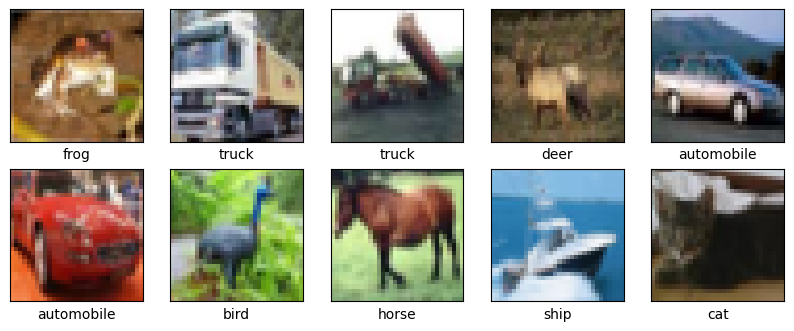

In [375]:
plot_cifar10_images(training_data.data, training_data.targets, 10)

In [376]:
print("Training images shape: ", training_data.data.shape)
print("Test images shape: ", test_data.data.shape)

training_data.data[0]

Training images shape:  (50000, 32, 32, 3)
Test images shape:  (10000, 32, 32, 3)


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## Preprocessing data

In [377]:
# Normalization
# training_data.data = training_data.data.astype("float32") / 255.0
# test_data.data = test_data.data.astype("float32") / 255.0

# training_data.data[0]

## Build cVAE model

[cVAE mechanism](https://idiotdeveloper.com/introduction-to-autoencoders/)

![cVAE mechanism](./images/variational-autoencoder.png)

Ref.

[Understanding Conditional Variational Autoencoders](https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8)

[Conditional Variational Autoencoder (cVAE) using PyTorch](https://github.com/unnir/cVAE)

[Conditional Variational Autoencoder in Keras](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

In [378]:
class CVAE(nn.Module):
    """
    需要以下三個結構
    1. encoder
    2. reparameterizer
    3. decoder
    """

    def __init__(self, feature_size, latent_size, class_size, *args, **kwargs) -> None:
        super(CVAE, self).__init__(*args, **kwargs)

        self.feature_size = feature_size
        self.class_size = class_size

        # encoder
        self.fc1 = nn.Linear(feature_size + class_size, fc_output_features)
        self.fc21 = nn.Linear(fc_output_features, latent_size)
        self.fc22 = nn.Linear(fc_output_features, latent_size)

        # decoder
        self.fc3 = nn.Linear(latent_size + class_size, fc_output_features)
        self.fc4 = nn.Linear(fc_output_features, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c):  # Q(z|x, c)
        """
        x: (bs, feature_size)
        c: (bs, class_size)
        """
        inputs = torch.cat([x, c], 1)  # (bs, feature_size + class_size)
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):  # P(x|z, c)
        """
        z: (bs, latent_size)
        c: (bs, class_size)
        """
        inputs = torch.cat([z, c], 1)  # (bs, latent_size + class_size)
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, self.feature_size), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size * image_size * chanel_num), reduction="sum")
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


model = CVAE(image_size * image_size * chanel_num, latent_size, class_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)


def train(epoch, data_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot(labels, class_size)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch, data_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            data, labels = data.to(device), labels.to(device)
            labels = one_hot(labels, class_size)
            recon_batch, mu, logvar = model(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n], recon_batch.view(-1, chanel_num, image_size, image_size)[:n]])
                save_image(
                    comparison.cpu(),
                    "./outputs/cifar-10-cvae-outputs/temp/reconstruction_" + str(f"{epoch:02}") + ".png",
                    nrow=n,
                )

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))


for epoch in range(1, epochs + 1):
    train(epoch, train_loader)
    test(epoch, validate_loader)
    with torch.no_grad():
        c = torch.eye(class_size, class_size).to(device)
        sample = torch.randn(class_size, latent_size).to(device)
        sample = model.decode(sample, c).cpu()
        images = sample.view(class_size, chanel_num, image_size, image_size)
        save_image(
            images,
            "./outputs/cifar-10-cvae-outputs/temp/sample_" + str(f"{epoch:02}") + ".png",
        )

Train Epoch: 1 [0/40000 (0%)]	Loss: 2144.489502
Train Epoch: 1 [1280/40000 (3%)]	Loss: 2088.240967
Train Epoch: 1 [2560/40000 (6%)]	Loss: 2038.437012
Train Epoch: 1 [3840/40000 (10%)]	Loss: 1988.487549
Train Epoch: 1 [5120/40000 (13%)]	Loss: 1959.511108
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1987.610962
Train Epoch: 1 [7680/40000 (19%)]	Loss: 1939.259399
Train Epoch: 1 [8960/40000 (22%)]	Loss: 1955.566284
Train Epoch: 1 [10240/40000 (26%)]	Loss: 1897.808105
Train Epoch: 1 [11520/40000 (29%)]	Loss: 1946.486328
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1894.060303
Train Epoch: 1 [14080/40000 (35%)]	Loss: 1945.936035
Train Epoch: 1 [15360/40000 (38%)]	Loss: 1891.719116
Train Epoch: 1 [16640/40000 (42%)]	Loss: 1874.293701
Train Epoch: 1 [17920/40000 (45%)]	Loss: 1899.930054
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1896.462402
Train Epoch: 1 [20480/40000 (51%)]	Loss: 1945.656982
Train Epoch: 1 [21760/40000 (54%)]	Loss: 1900.931030
Train Epoch: 1 [23040/40000 (58%)]	Loss: 1887.643555
Train E